# Progetto Web&IR
### Obiettivo : Classificare argomento notizia in base a :
1. Headline
2. Short description
#### Cosa andremo a fare :
* Esplorazione dei dati
* Preprocessamento
* Addestramento
* Valutazione

In [50]:
#Definzione delle librerie necessarie
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.validation import check_X_y
import json
import csv
from sklearn.feature_selection import SelectPercentile

In [22]:
# Apriamo e leggiamo il file json
with open('News_Category_Dataset.json', 'r') as json_file:
    # Iteriamo sul file
    for line in json_file:
        item = json.loads(line)

        # Estraiamo i campi
        link = item.get('link', '')
        headline = item.get('headline', '')
        category = item.get('category', '')
        short_description = item.get('short_description', '')
        authors = ', '.join(item.get('authors', []))
        date = item.get('date', '')

        # Scriviamo i campi nel file csv
        with open('News_Category_Dataset.csv', 'a', newline='', encoding='utf-8') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow([link, headline, category, short_description, authors, date])

In [23]:
# Definiamo le colonne
column_types = {
    'link': str,
    'headline': str,
    'category': str,
    'short_description': str,
    'authors': str,
    'date': str
}

# Riscriviamo 
column_names = ['link', 'headline', 'category', 'short_description', 'authors', 'date']

df = pd.read_csv('News_Category_Dataset.csv', dtype=column_types, names=column_names)

### Data Esploration

In [24]:
print(df.shape)

(419054, 6)


In [25]:
print(df.head())

                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  \
0  Health experts said it is too early to predict...   
1  He was subdued by passengers and crew when he ...   
2  "Until you have a dog you don't understand wha...   
3  "Accidentally put grown-up toothp

In [26]:
print(df.dtypes)

link                 object
headline             object
category             object
short_description    object
authors              object
date                 object
dtype: object


In [27]:
print('Valori null: ')
print(df.isnull().sum())

Valori null: 
link                     0
headline                12
category                 0
short_description    39424
authors              74836
date                     0
dtype: int64


Le colonne link, authors e date sono inutili per il classificatore, quindi li droppiamo :

In [28]:
df = df.drop('link', axis=1)
df = df.drop('authors', axis=1)
df = df.drop('date', axis=1)

E dato che ci sono circa 20.000 istanze nulle nella 'short_description' droppiamo anche quelle :

In [29]:
df.dropna(subset=["short_description"], inplace=True)
df.dropna(subset=["headline"], inplace=True)
print(df.head(),'\n')
print(df.isnull().sum())

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  
0  Health experts said it is too early to predict...  
1  He was subdued by passengers and crew when he ...  
2  "Until you have a dog you don't understand wha...  
3  "Accidentally put grown-up toothpaste on my to...  
4  Amy Cooper accused investment firm Franklin Te...   

headline             0
category             0
short_description    0
dtype: int64


Ora vediamo la distribuzione delle classi di category.

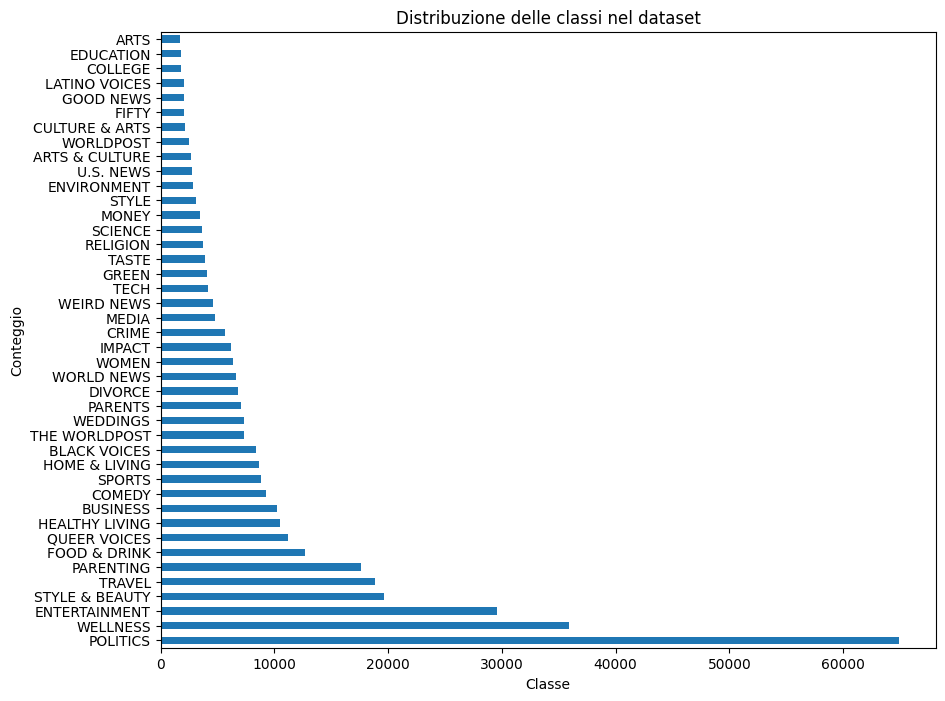

In [30]:
counts = df['category'].value_counts()
plt.figure(figsize=(10, 8))
counts.plot(kind='barh')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.title('Distribuzione delle classi nel dataset')
plt.show()

Dato che sono troppe classi e troppo sbilanciate tra loro prendo solamente un sottoinsieme delle classi totali :

In [31]:
classi_da_includere = ['DIVORCE', 'PARENTS', 'WEDDINGS', 'THE WORLDPOST', 'BLACK VOICES', 'SPORTS']
df = df[df['category'].isin(classi_da_includere)]

Rivediamo il grafico :

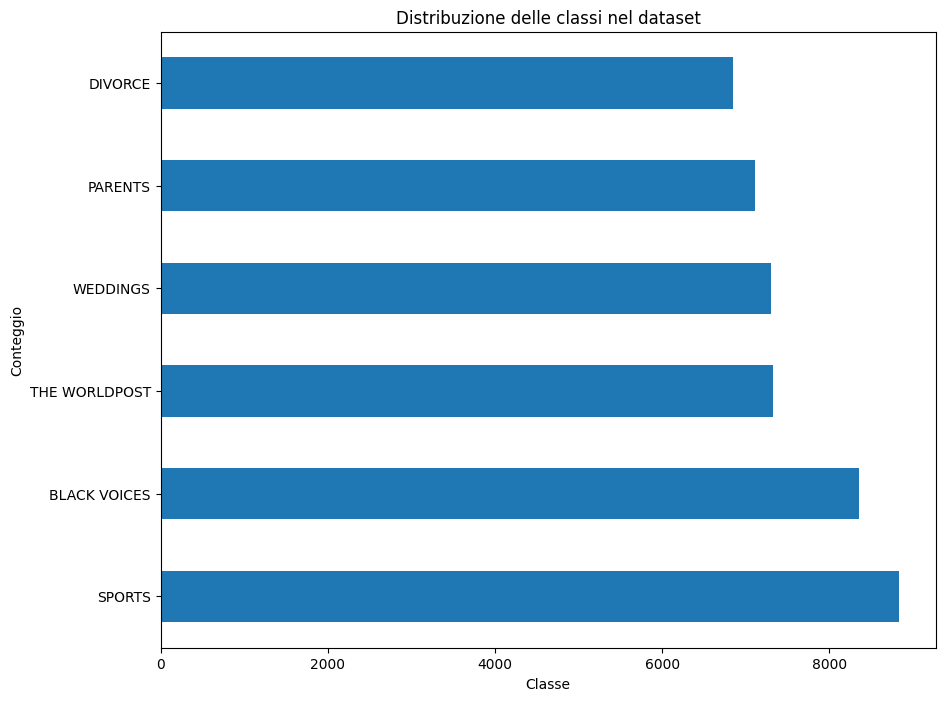

In [32]:
counts = df['category'].value_counts()
plt.figure(figsize=(10, 8))
counts.plot(kind='barh')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.title('Distribuzione delle classi nel dataset')
plt.show()

Andiamo a definire una funzione di preprocessamento del testo :

### Preprocessamento

In [54]:
def transformText(text):
    #Identifichiamo le stop words
    stops = set(stopwords.words("english"))
    #Eseguiamo una conversione lowercase di tutte le word
    text = text.lower()
    #Rimozione dei numerici
    text = gensim.parsing.preprocessing.strip_numeric(text)
    #Rimozione degli spazi bianchi multipli consecutivi da una stringa di testo
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    #Divisione delle words usando split() ed aggiunta nella lista word se non presenti in stops
    filtered_words = [word for word in text.split() if word not in stops]
    #Join con parole filtrate o processate.
    text = " ".join(filtered_words)
    #Rimozione della punteggiatura
    text = gensim.parsing.preprocessing.strip_punctuation(text)
    #Rimozione di tutte le word aventi lunghezza < 3
    text = gensim.parsing.preprocessing.strip_short(text, minsize=3)
    # Inizializziamo il lemmatizzatore di NLTK
    lemmatizer = WordNetLemmatizer()
    # Lemmatizzazione delle words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [56]:
#Applichiamo transformText tutte le righe del dataset
df1 = df.copy()
df1['headline'] = df['headline'].map(transformText)
df1['short_description'] = df['short_description'].map(transformText)
print(df1.head())

                                             headline category  \
17       maury will base stealing shortstop dodger dy   SPORTS   
26  la vega ace win first wnba title chelsea gray ...   SPORTS   
61  boston marathon make race inclusive nonbinary ...   SPORTS   
62  anthony varvaro mlb pitcher turned transit cop...   SPORTS   
67     carlos alcaraz win open slam title top ranking   SPORTS   

                                    short_description  
17  maury will helped los angeles dodger win three...  
26   la vega never professional sport champion sunday  
61  race organizer say nonbinary athlete register ...  
62  varvaro pitched mostly atlanta brave started l...  
67  carlos alcaraz defeated casper ruud open final...  


Dopo aver preprocessato il testo andiamo a creare due dataframe, ognuno con due colonne, per poter creare e confrontare due modelli, uno addestrato su 'headline' e l'altro invece su 'short_description' 

In [57]:
# Suddivide gli attributi e la classe target in set di addestramento e test
X1_train, X1_test, y1_train, y1_test = train_test_split(df1['headline'], df1['category'], test_size=0.20, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(df1['short_description'], df1['category'], test_size=0.20, random_state=42)
print('Vediamo le due train_test_split:\n')
print(y1_train.value_counts(),'\n')
print(y2_train.value_counts())

Vediamo le due train_test_split:

SPORTS           7038
BLACK VOICES     6658
WEDDINGS         5883
THE WORLDPOST    5874
PARENTS          5712
DIVORCE          5459
Name: category, dtype: int64 

SPORTS           7038
BLACK VOICES     6658
WEDDINGS         5883
THE WORLDPOST    5874
PARENTS          5712
DIVORCE          5459
Name: category, dtype: int64


In [58]:
#Definizione della pipeline con tutti i suoi passaggi
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()), #trasformazione TF-IDF
    ("selector", SelectPercentile()),
    ("clf", SVC(kernel='linear')),
])

In [59]:
parameters = {
    'tfidf__use_idf': (True, False), #Uso del parametro ID
    'selector__percentile': (30,40), #Percentuale feature più importanti
    'clf__C': (1, 10), #Valore parametro C
}

### Addestramento e Valutazione
* Primo modello ( headline )
* Secondo modello ( short_description )
  

#### Primo modello :

In [60]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, error_score='raise')

print(parameters)
t0 = time()

#Fit della GridSearchCV
grid_search.fit(X1_train, y1_train)

#Stampa del tempo impiegato dall'esecuzione
print("Tempo di esecuzione: %0.3fs" % (time() - t0))
print()

#Stampa dei parametri ottimali
print("Best score: %0.3f" % grid_search.best_score_)
print("Migliore configurazione:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

{'tfidf__use_idf': (True, False), 'selector__percentile': (30, 40), 'clf__C': (1, 10)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tempo di esecuzione: 901.920s

Best score: 0.905
Migliore configurazione:
	clf__C: 10
	selector__percentile: 40
	tfidf__use_idf: True


In [61]:
best_pipe = grid_search.best_estimator_

#Definizione della cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Esecuzione della cross-validation
scores = []
for train_index, val_index in cv.split(X1_train, y1_train):
    #Insiemi di addestramento e validazione
    X_cv_train, X_cv_val = X1_train.iloc[train_index], X1_train.iloc[val_index]
    y_cv_train, y_cv_val = y1_train.iloc[train_index], y1_train.iloc[val_index]
    
    # Fit del modello sulla porzione di training del fold corrente
    best_pipe.fit(X_cv_train, y_cv_train)
    
    # Valutazione del modello sul fold di validazione corrente
    score = best_pipe.score(X_cv_val, y_cv_val)
    scores.append(score)

#Media dei punteggi
mean_score = sum(scores) / len(scores)

#Stampa dei risultati della cross-validation
print("Cross-Validation Scores:", scores)
print("Mean Score:", mean_score)

Cross-Validation Scores: [0.9063609063609064, 0.9167349167349167, 0.924924924924925, 0.9197379197379197, 0.9098853085745494, 0.9194429273620972, 0.9180775532495904, 0.9194429273620972, 0.9180775532495904, 0.9216275259421082]
Mean Score: 0.9174312463498702


In [62]:
predicted = best_pipe.predict(X1_test)

In [63]:
print('Confusion matrix: \n', confusion_matrix(y1_test, predicted))
print(metrics.classification_report(y1_test, predicted))

Confusion matrix: 
 [[1553   13   52   53   15   10]
 [  47 1198   59    9    5   75]
 [  42   36 1272   14   14   22]
 [  47    5   25 1690   22    1]
 [  34    4   15   13 1383    5]
 [  23   30   17    6    4 1343]]
               precision    recall  f1-score   support

 BLACK VOICES       0.89      0.92      0.90      1696
      DIVORCE       0.93      0.86      0.89      1393
      PARENTS       0.88      0.91      0.90      1400
       SPORTS       0.95      0.94      0.95      1790
THE WORLDPOST       0.96      0.95      0.95      1454
     WEDDINGS       0.92      0.94      0.93      1423

     accuracy                           0.92      9156
    macro avg       0.92      0.92      0.92      9156
 weighted avg       0.92      0.92      0.92      9156



#### Secondo modello :

In [64]:
grid_search2 = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10)

print(parameters)
t0 = time()

#Fit della GridSearchCV
grid_search2.fit(X2_train, y2_train)

#Stampa del tempo impiegato dall'esecuzione
print("Tempo di esecuzione: %0.3fs" % (time() - t0))
print()

#Stampa dei parametri ottimali
print("Best score: %0.3f" % grid_search2.best_score_)
print("Migliore configurazione:")
best_parameters2 = grid_search2.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters2[param_name]))

{'tfidf__use_idf': (True, False), 'selector__percentile': (30, 40), 'clf__C': (1, 10)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tempo di esecuzione: 4463.519s

Best score: 0.822
Migliore configurazione:
	clf__C: 10
	selector__percentile: 40
	tfidf__use_idf: True


In [68]:
best_pipe2 = grid_search2.best_estimator_

#Definizione della cross-validation
cv2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Esecuzione della cross-validation
scores2 = []
for train_index, val_index in cv2.split(X2_train, y2_train):
    #Insiemi di addestramento e validazione
    X2_cv_train, X2_cv_val = X2_train.iloc[train_index], X2_train.iloc[val_index]
    y2_cv_train, y2_cv_val = y2_train.iloc[train_index], y2_train.iloc[val_index]
    
    # Fit del modello sulla porzione di training del fold corrente
    best_pipe2.fit(X2_cv_train, y2_cv_train)
    
    # Valutazione del modello sul fold di validazione corrente
    score2 = best_pipe2.score(X2_cv_val, y2_cv_val)
    scores2.append(score2)

#Media dei punteggi
mean_score2 = sum(scores2) / len(scores2)

#Stampa dei risultati della cross-validation
print("Cross-Validation Scores:", scores2)
print("Mean Score:", mean_score2)

Cross-Validation Scores: [0.8372918372918373, 0.8416598416598416, 0.8479388479388479, 0.8419328419328419, 0.8394320043691972, 0.8388858547241944, 0.8375204806116876, 0.8536318951392682, 0.84598580010923, 0.8413435281267068]
Mean Score: 0.8425622931903654


In [69]:
predicted2 = best_pipe2.predict(X2_test)

In [70]:
print('Confusion matrix: \n', confusion_matrix(y2_test, predicted2))
print(metrics.classification_report(y2_test, predicted2))

Confusion matrix: 
 [[1409   18   87  121   47   14]
 [  42 1209   49   17    2   74]
 [  84   49 1108  114   11   34]
 [ 106    9   60 1560   48    7]
 [  87    4   40   68 1245   10]
 [  31   79   31   26   10 1246]]
               precision    recall  f1-score   support

 BLACK VOICES       0.80      0.83      0.82      1696
      DIVORCE       0.88      0.87      0.88      1393
      PARENTS       0.81      0.79      0.80      1400
       SPORTS       0.82      0.87      0.84      1790
THE WORLDPOST       0.91      0.86      0.88      1454
     WEDDINGS       0.90      0.88      0.89      1423

     accuracy                           0.85      9156
    macro avg       0.85      0.85      0.85      9156
 weighted avg       0.85      0.85      0.85      9156

